# Import Module

In [35]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

# Settings

### Variables

In [36]:
variables = ['rlut']
variable = 'LW'
TITLE = 'Long Wave fluxes'
ylabel = '$E_{LW}$ ($W.m^{-2}.K^{-1}$)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/'

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [5]:
def get_3D_LW_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    LW = df['rlut']
    
    return LW

In [6]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    #list_ind = []
    #cpt=0
    #for i in df1['year'] : 
    #    if i>1981 :
    #        list_ind.append(cpt)
    #        cpt+=1
    #    else : 
    #        cpt+=1
            
    #df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

# Get data : obs, PPE, p1

In [7]:
path_observation = '/data/scratch/globc/peatier/obs_data/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'

In [8]:
# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename,combine='by_coords')
#file
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)
df_obs

toa_sw_all_mon  toa_lw_all_mon  toa_net_all_mon
month lat        lon                                                       
1     -88.927735 0.00000        344.953522      189.246185       -38.599289
                 1.40625        344.953522      189.246185       -38.599289
                 2.81250        344.953522      189.246185       -38.599289
                 4.21875        344.992493      189.144440       -38.531315
                 5.62500        345.007721      189.104630       -38.504715
...                                    ...             ...              ...
12     88.927735 352.96875        0.000000      171.476639      -171.476639
                 354.37500        0.000000      171.476639      -171.476639
                 355.78125        0.000000      171.500351      -171.500351
                 357.18750        0.000000      171.560974      -171.560974
                 358.59375        0.000000      171.560974      -171.560974

[393216 rows x 3 columns]

In [9]:
df_obs[variable] =  df_obs['toa_lw_all_mon']
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:          (lat: 128, lon: 256)
Coordinates:
  * lat              (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon              (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
Data variables:
    toa_sw_all_mon   (lat, lon) float32 121.35958 121.35958 ... 103.85324
    toa_lw_all_mon   (lat, lon) float32 142.8201 142.8201 ... 194.14125
    toa_net_all_mon  (lat, lon) float32 -91.40278 -91.40278 ... -126.49493
    LW               (lat, lon) float32 142.8201 142.8201 ... 194.14125

In [10]:
variables = ['rlut']

# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_LW_xarr(path, filename, variables)

In [11]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_LW_xarr(path, filename, variables)
    i=i+1

In [12]:
amip['p1'] = p1_amip

# Calcule full RMSE (ej)

In [37]:
n_lat = len(obs['lat'])
n_lon = len(obs['lon'])
N = (n_lat*n_lon)

# Reference p1
diff = (amip['p1'] - obs['LW'])**2
diff_p1 = sqrt(sum(diff))/N
diff_p1

<xarray.DataArray ()>
dask.array<truediv, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...

In [38]:
ej = {}
#ej['p1'] = diff_p1

for p in nb_p_list :
    diff_tmp = (amip[p] - obs['LW'])**2
    diff = sqrt(diff_tmp.sum(dim=['lat', 'lon']))/N
    ej[p] = diff

### Save

In [39]:
np.save(path_files+'npy/CNRMppe_decomposition_ej_'+str(variable)+'.npy', ej)

# EOF + truncated RMSE (rj)

## EOF

In [16]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    amip_list[i+1] = tmp
    i+=1

In [17]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])

In [19]:
# Compute anomalies by removing the ensemble-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean

In [20]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom, center=False)

In [21]:
eof = solver.eofsAsCovariance(neofs=100, pcscaling=1)
pc = solver.pcs(npcs=100, pcscaling=0)

In [22]:
varFrac = solver.varianceFraction(neigs=100)
varFrac

<xarray.DataArray 'variance_fractions' (mode: 100)>
array([6.1045539e-01, 1.2273171e-01, 7.9940438e-02, 3.5465352e-02,
       2.6840350e-02, 1.7525854e-02, 1.1545944e-02, 1.0070055e-02,
       7.4010189e-03, 5.7481071e-03, 4.9017412e-03, 4.6232366e-03,
       3.6081113e-03, 3.1355512e-03, 2.7246338e-03, 2.6189913e-03,
       2.3591879e-03, 2.2541222e-03, 1.9848195e-03, 1.7995620e-03,
       1.7014040e-03, 1.5998890e-03, 1.5084344e-03, 1.4725542e-03,
       1.2780163e-03, 1.2523885e-03, 1.1993136e-03, 1.1451484e-03,
       1.0633832e-03, 1.0458246e-03, 1.0000528e-03, 9.4922713e-04,
       9.0249768e-04, 8.5777865e-04, 8.2751026e-04, 7.7771355e-04,
       7.3905662e-04, 7.2585716e-04, 6.9897989e-04, 6.9567218e-04,
       6.7374512e-04, 6.6577597e-04, 6.5320858e-04, 6.1657606e-04,
       5.7698943e-04, 5.5782404e-04, 5.4780935e-04, 5.3540786e-04,
       5.2368618e-04, 5.0097896e-04, 4.8520608e-04, 4.8093128e-04,
       4.5413111e-04, 4.4424413e-04, 4.3156656e-04, 4.2999513e-04,
       4.2300308e-04, 4.1359628e-04, 4.0805907e-04, 4.0111129e-04,
       3.8572695e-04, 3.7710133e-04, 3.6513715e-04, 3.5710415e-04,
       3.5082846e-04, 3.4568436e-04, 3.4235200e-04, 3.3388400e-04,
       3.2493396e-04, 3.1890481e-04, 3.1705675e-04, 2.9972137e-04,
       2.9747954e-04, 2.8940389e-04, 2.7629791e-04, 2.7224468e-04,
       2.7041559e-04, 2.6530083e-04, 2.5130858e-04, 2.5036011e-04,
       2.4354085e-04, 2.4021702e-04, 2.3955161e-04, 2.2835897e-04,
       2.2747602e-04, 2.2188858e-04, 2.1509083e-04, 2.1281984e-04,
       2.0932707e-04, 2.0230915e-04, 1.9672765e-04, 1.9330053e-04,
       1.9041702e-04, 1.8428755e-04, 1.8075638e-04, 1.7944796e-04,
       1.7325048e-04, 1.6787052e-04, 1.5704632e-04, 1.5498397e-04],
      dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Attributes:
    long_name:  variance_fractions

### Save

In [23]:
for i in range(0,len(eof),1) : 
    j = i+1
    # EOFmap
    EOF_df = eof[i].to_dataframe().drop(labels = 'mode', axis=1)
    EOF_df.to_pickle(path_files+"npy/CNRMppe_decomposition_EOFmap"+str(j)+"_"+str(variable)+".npy")
    
    #EOFpc
    pc_p1 = pc[0, i]
    pc_mb = pc[1:, i]
    np.save(path_files+'npy/CNRMppe_decomposition_p1_EOF'+str(j)+'pc_'+str(variable)+'.npy', pc_p1)
    np.save(path_files+'npy/CNRMppe_decomposition_EOF'+str(j)+'pc_'+str(variable)+'.npy', pc_mb)

In [24]:
mean_df = mean.to_dataframe(name=str(variable)+'mean').drop(labels = 'height', axis=1)
mean_df.to_pickle(path_files+'npy/CNRMppe_decomposition_mean_'+str(variable)+'.npy')

## Get the observations

In [25]:
Mean =  pd.read_pickle(path_files+'npy/CNRMppe_decomposition_mean_'+str(variable)+'.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
X_obs = obs['LW'] - Mean
#X_obs = obs.expand_dims(dim={'dummy':range(0,102,1)})
#X_obs = obs.fillna(0.0)
X_obs

<xarray.DataArray (lat: 128, lon: 256)>
array([[1.3436279 , 1.3436279 , 1.3436279 , ..., 1.5608673 , 1.3436279 ,
        1.3436279 ],
       [0.6392975 , 0.6392975 , 0.6392975 , ..., 1.3332672 , 0.6392975 ,
        0.6392975 ],
       [0.79974365, 0.79974365, 0.79974365, ..., 1.3285065 , 0.79974365,
        0.79974365],
       ...,
       [5.537903  , 5.537903  , 5.537903  , ..., 5.31102   , 5.537903  ,
        5.537903  ],
       [4.882019  , 4.882019  , 4.882019  , ..., 4.798538  , 4.882019  ,
        4.882019  ],
       [6.381012  , 6.381012  , 6.381012  , ..., 6.3507233 , 6.381012  ,
        6.381012  ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U6 'LWmean'

In [40]:
def Error_rj(cpt, U_obs, variable):
    rj_list = []
    for i in range(0,len(U_obs),1) :
        j=i+1
        pc = np.load(path_files+'npy/CNRMppe_decomposition_EOF'+str(j)+'pc_'+str(variable)+'.npy')
        diff = (U_obs[i]-pc[cpt])**2
        rj_list.append(diff)
        #print(pc[cpt])
        #print(U_obs[i])
        #print(diff)
    rj_E = sqrt(sum(rj_list))/N
    return rj_E

## Emulation

In [27]:
def MultiLinReg(limit_train, EOF_nb, x, variable) :
    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file=path_files+'npy/CNRMppe_decomposition_EOF'+str(EOF_nb)+'pc_'+str(variable)+'.npy')
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X[0:limit_train], y[0:limit_train])
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]
  
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [28]:
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
pc_pred={}


def predict_member(X, EOF_nb) :
    tmp_list = []
    for x in X[80:] :
        tmp = MultiLinReg(80, EOF_nb, x, variable)
        tmp_list.append(tmp)
    return tmp_list
    
for i in range(1,101,1) : 
    pc_pred['modes_'+str(i)] = predict_member(X, i)

#pc_pred

In [29]:
df_pc_pred = pd.DataFrame(pc_pred['modes_1'], columns=['modes_1'])
for i in range(1,101,1) :
    df_pc_pred['modes_'+str(i)] = pc_pred['modes_'+str(i)]
    
df_pc_pred

,modes_1,modes_2,modes_3,modes_4,modes_5,modes_6,modes_7,modes_8,modes_9,modes_10,...,modes_91,modes_92,modes_93,modes_94,modes_95,modes_96,modes_97,modes_98,modes_99,modes_100
0,-1621.089510,27.912583,-7.421215,-2.642505,-138.289369,-42.842720,80.209163,-61.402247,-42.104057,54.628312,...,11.469488,-2.737441,-5.886531,-5.825459,-11.978841,-17.638479,13.397424,-19.717313,-11.070374,-9.496825
1,-1027.084874,1066.253397,-188.995000,129.963359,-124.306451,25.207426,85.851248,152.155120,125.546449,-73.579045,...,8.771579,-1.886331,-0.259273,-3.723937,1.629096,-5.163161,5.257161,-1.766867,-18.213577,5.982087
2,306.395986,-457.674663,-182.960874,101.299939,146.381706,-76.047546,161.937012,-83.656749,-2.431338,55.690851,...,-10.832030,2.393602,-13.090651,7.181607,-14.834505,7.212354,-4.612207,32.424563,24.690565,3.750416
3,135.329780,15.210029,-175.539572,-293.023324,417.564596,-119.317893,-20.017483,-126.263019,-81.023421,55.337783,...,2.329379,9.687299,3.099945,-1.412198,1.531751,16.170178,-5.268029,36.733071,5.724370,17.565394
4,-1793.010178,-199.770817,-159.422908,-267.370998,306.207005,45.518628,21.404367,60.979021,-90.180206,-28.383295,...,4.115435,-9.263462,-5.508263,-6.641691,-8.601838,15.061973,-12.079690,3.729289,4.687663,11.389530
5,229.712685,395.900828,37.186421,-19.912400,-108.608388,-95.578656,4.183527,-9.581880,-12.090534,-9.049630,...,0.777349,11.821442,7.788785,3.558364,14.957720,1.118425,14.398489,-10.084523,-16.323922,-9.390480
6,-729.361280,215.979609,168.968359,-124.780843,-169.162967,-97.369815,-123.241987,0.268085,54.054218,100.417933,...,2.631116,-5.647793,-2.920064,5.389805,9.902078,-4.719262,-25.163768,6.098099,17.319367,-2.162500
7,-158.917480,621.111921,546.776048,41.690364,57.168018,86.902586,-85.811140,154.367788,70.576157,-28.530930,...,20.099718,-18.100443,10.369353,-0.716927,14.840568,12.496203,10.975880,-25.003732,-11.058401,16.738608
8,511.143213,352.755904,-57.960871,160.630805,28.646949,151.783310,-55.289102,30.011712,-27.688408,21.515958,...,13.889011,7.320957,-3.030013,-14.265733,9.053056,-3.022952,10.521718,6.656395,-17.147252,14.436467
9,-129.223172,-430.471268,-152.055070,115.250274,-61.272772,107.699655,-81.901639,106.461097,-23.701993,72.033411,...,-3.766404,2.307685,-7.899481,-2.535115,0.541550,-5.762664,12.943453,-8.092151,-22.104401,-21.399574


In [41]:
def Error_rj_pred(U_obs, variable, p):
    rj_pred_list = []
    for i in range(0,len(U_obs),1) :
        j=i+1
        pc_pred = df_pc_pred['modes_'+str(i+1)] 
        diff = (U_obs[i]-pc_pred[p])**2
        rj_pred_list.append(diff)
        
    rj_pred = sqrt(sum(rj_pred_list))/N
    return rj_pred

# Loop over 1 to 100 modes considered

In [42]:
ej_list = []
for p in nb_p_list :
    ej_tmp = ej[p]
    ej_list.append(ej_tmp)

In [43]:
df_corr = pd.DataFrame(ej_list, columns=['ej'])
df_corr_pred = pd.DataFrame(ej_list[80:], columns=['ej'])
r_corr = {}
r_corr_pred = {}
frac = {}

for i in range(1,101,1) :
    U_obs = solver.projectField(X_obs, neofs=i, weighted=False, eofscaling=0)
    
    rj_list=[]
    cpt=0
    for p in nb_p_list:
        tmp = Error_rj(cpt, U_obs, variable)
        rj_list.append(tmp)
        cpt+=1
        
    rj_pred_list = []
    for p in range(0,22,1) : 
        tmp = Error_rj_pred(U_obs, variable, p)
        rj_pred_list.append(tmp)
    
    df_corr['rj'] = rj_list
    df_corr['frac'] = abs(df_corr['ej']-df_corr['rj'])/df_corr['ej']    
    r_corr_tmp = np.corrcoef(df_corr['ej'], df_corr['rj'])
    r_corr['modes_'+str(i)]  = r_corr_tmp[1,0]
    frac['modes_'+str(i)] = df_corr['frac'].mean()    
    
    df_corr_pred['rj_pred'] = rj_pred_list
    r_corr_pred_tmp = np.corrcoef(df_corr_pred['ej'], df_corr_pred['rj_pred'])
    r_corr_pred['modes_'+str(i)] = r_corr_pred_tmp[1,0]


In [44]:
frac_list = []
r_corr_list=[]
r_corr_pred_list = []

for i in range(1,101,1) : 
    frac_tmp = frac['modes_'+str(i)]
    r_tmp = r_corr['modes_'+str(i)]
    r_corr_pred_tmp = r_corr_pred['modes_'+str(i)]
    frac_list.append(frac_tmp)
    r_corr_list.append(r_tmp)
    r_corr_pred_list.append(r_corr_pred_tmp)

df_fig = pd.DataFrame(r_corr_list, columns=['r_corr'])
df_fig['frac'] = frac_list
df_fig['r_corr_pred'] = r_corr_pred_list
df_fig['mode'] = range(1,101,1)
df_fig

,r_corr,frac,r_corr_pred,mode
0,0.822085,0.627915,0.577783,1
1,0.899532,0.496610,0.708178,2
2,0.979620,0.272375,0.762478,3
3,0.981848,0.261505,0.758281,4
4,0.984306,0.238973,0.768748,5
...,...,...,...,...
95,0.999851,0.062647,0.751491,96
96,0.999851,0.062511,0.751431,97
97,0.999852,0.062406,0.751403,98
98,0.999852,0.062288,0.751569,99


# Figure

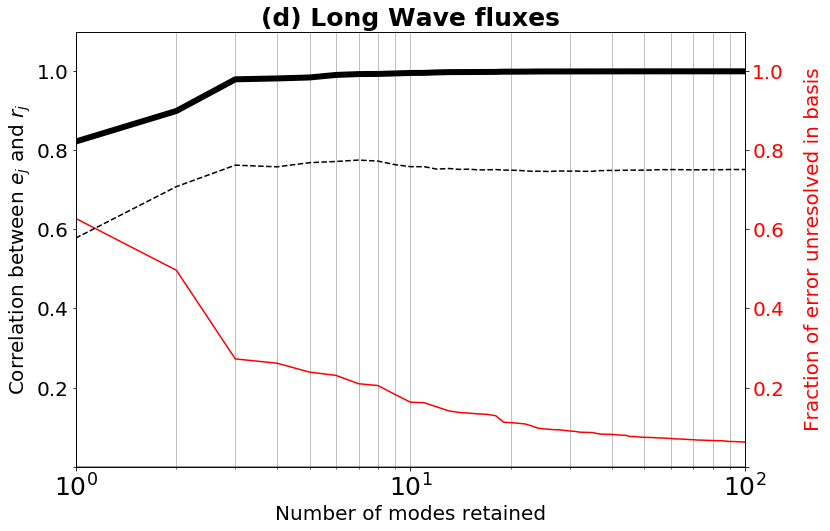

In [45]:
plt.figure(figsize=(12, 8))
    

ax = plt.gca()
ax2 = ax.twinx()

df_fig.plot(kind='line', x='mode', y='r_corr', color = 'black', alpha=1, linewidth=6, ax=ax)
df_fig.plot(kind='line', x='mode', y='frac', color='red', linestyle='-', linewidth=1.5, ax=ax)
df_fig.plot(kind='line', x='mode', y='r_corr_pred', color='black', linestyle='dashed', linewidth=1.5, ax=ax)

ax.axhline(0, color='k', alpha=0.5)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Number of modes retained', size = 20)
ax.set_ylabel('Correlation between $e_j$ and $r_j$', size = 20)
ax.set_title('(d) '+TITLE, fontsize=25, 
             fontweight = 'bold')
ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=25)
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)

new_tick_locations = np.array([None, 0.2, 0.4, 0.6, 0.8, 1.0])

ax2.set_ylim(ax.get_ylim())
#ax2.set_xticks(new_tick_locations)
ax2.set_yticklabels(new_tick_locations, color='red')
ax2.set_ylabel("Fraction of error unresolved in basis", color='red', fontsize=20, labelpad=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

# Legend .................

#legend = [ 'Correlation', 'Unresolved fraction']
ax.get_legend().remove()
#ax.legend(legend, fontsize=25, bbox_to_anchor=(1.65, 0.83)) #bbox_to_anchor=(1.05, 1)
#fig.subplots_adjust(right=0.8)

# Grid .................
ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Fig1_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()
